<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_Week3_Ensemble_Learning_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 개념 필사 - 0325(금) 3주차 과제
 
## <핸즈온 머신러닝>
## Chapter 7 앙상블 학습과 랜덤 포레스트

* 앙상블 학습(ensemble learning) : 일련의 예측기(앙상블)로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻는 것

* 랜덤 포레스트(random forest) : 결정 트리의 앙상블

### 7.1 투표 기반 분류기
* 직접 투표(hard voting) 분류기 : 다수결 투표로 정해지는 분류기
  - 각 분류기가 약한 학습기(weak learner)일지라도 충분히 많고 다양 -> 앙상블은 강한 학습기(strong learner)가 될 수 있음

* 예측기가 가능한 한 서로 독립적일 때 앙상블 방법이 최고의 성능을 발휘 -> 각기 다른 알고리즘으로 학습

In [1]:
# moons 데이터셋 불러온 후, 훈련/테스트 데이터 세트로 분리
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
# 여러 분류기 조합하여 VotingClassifier 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.912


* 간접 투표(soft voting) : 모든 분류기가 predict_proba() 메서드가 있어서 클래스의 확률을 예측할 수 있는 경우, 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 방법
  - 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
  - voting = "soft"
  - SVC : probability = True


### 7.2 배깅과 페이스팅
* 배깅(bagging) : 훈련 세트에서 중복을 허용하여 샘플링 하는 방식
* 페이스팅(pasting) : 훈련 세트에서 중복을 허용하지 않고 샘플링 하는 방식

-> 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음

* 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음

* 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측 생성
  - 수집 함수
    - 분류 : 통계적 최빈값(statistical mode)
    - 회귀 : 평균
  - 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소
  - 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

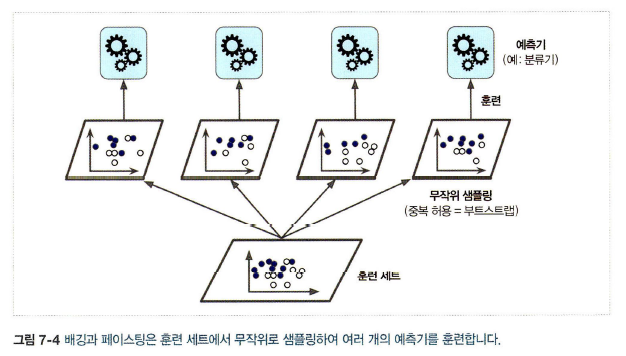


* 예측기는 모두 동시에 다른 CPU 코어나 서버에서  병렬 학습 및 예측 수행 가능 - "확장성"


#### 7.2.1 사이킷런의 배깅과 페이스팅
* BaggingClassifier (분류)
  - 기반 분류기가 클래스 확률 추정 가능(predict_proba() 함수 존재, 예: 결정 트리 분류기)
    
    -> 자동으로 간점 투표 방식 사용
* BaggingRegressor (회귀)

In [4]:
# 결정 트리 분류기 500개의 앙상블 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

* bootstrap : 배깅(True) / 페이스팅(False)
* n_jobs : 훈련과 예측에 사용할 CPU 코어 수 지정
  - 가용한 모든 코어 사용 (-1) / 기본값 (1)

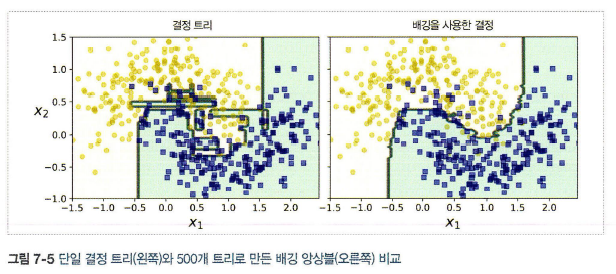

* 훈련 세트의 오차 수가 거의 비슷하지만 앙상블의 결정 경계가 덜 불규칙

* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가

  -> 배깅이 페이스팅보다 편향이 조금 더 높고, 분산은 작음

  => 일반적으로 배깅을 더 선호

#### 7.2.2 oob 평가
* BaggingClassifier에서는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링됨
* oob(out-of-bag) 샘플 : 선택되지 않은 훈련 샘플의 나머지 37%
  - oob 샘플을 사용해 평가 가능
  
  => 각 예측기의 oob 평가를 평균하여 앙상블 평가 수행
  - oob_score = True : 훈련 종료 후 자동으로 oob 평가 수행
  - oob_score_ : 평가 점수 결과가 저장되는 변수
  - oob_decision_function_ : oob 샘플에 대한 결정 함수의 값을 저장하는 변수
    -> 결정 함수는 각 훈련 샘플의 클래스 확률 반환

In [5]:
# oob 평가 수행
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [6]:
# 정확도 계산
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [7]:
# oob 샘플에 대한 결정 함수 값 확인
bag_clf.oob_decision_function_

array([[0.4695122 , 0.5304878 ],
       [0.32183908, 0.67816092],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.0755814 , 0.9244186 ],
       [0.38202247, 0.61797753],
       [0.00574713, 0.99425287],
       [0.99415205, 0.00584795],
       [0.9760479 , 0.0239521 ],
       [0.7797619 , 0.2202381 ],
       [0.01025641, 0.98974359],
       [0.75675676, 0.24324324],
       [0.85082873, 0.14917127],
       [0.96774194, 0.03225806],
       [0.05882353, 0.94117647],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.94915254, 0.05084746],
       [0.99487179, 0.00512821],
       [0.02105263, 0.97894737],
       [0.33333333, 0.66666667],
       [0.88235294, 0.11764706],
       [1.        , 0.        ],
       [0.975     , 0.025     ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6519337 , 0.3480663 ],
       [0.

### 7.3 랜덤 패치와 랜덤 서브스페이스
* BaggingClassifier는 특성 샘플링 지원
  - max_features, bootstrap_features
  - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
  - 이미지 등의 매우 고차원의 데이터셋을 다룰 때 유용
* 랜덤 패치 방식(random patches method) : 훈련 특성과 샘플을 모두 샘플링
* 랜덤 서브스테이스 방식(random subspaces method) : 훈련 샘플을 모두 사용(bootstrap=False이고 max_samples=1.0으로 설정)하고 특성은 샘플링(bootstrap_features=True 그리고/또는 max_features < 1.0 으로 설정)
* 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산 낮춤

### 7.4 랜덤 포레스트
* 랜덤 포레스트 : 배깅(또는 페이스팅)을 적용한 결정 트리의 앙상블
  - max_samples : 훈련 세트의 크기 지정
  - 몇 가지 예외를 제외한 DecisionTreeClassifier(트리 성장 조절)/BaggingClassifier(앙상블 자체 제어)의 매개 변수를 모두 가지고 있음
  - 트리의 노드를 분할할 때 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입 -> 트리 더욱 다양해짐 -> 편향 손해보는 대신 분산을 감소 -> 전체적으로 더 훌륭한 모델 생성
* RandomForestClassifier (분류)
* RandomForestRegressor (회귀)

In [8]:
# 500개의 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [10]:
# BaggingClassifier를 사용해 RandomForestClassifier와 유사하게 만듦
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
                           n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

#### 7.4.1 엑스트라 트리
* 익스트림 랜덤 트리(extremely randomized trees) 앙상블 (엑스트라 트리(extra-trees) : 극단적으로 무작위한 트리의 랜덤 포레스트
  - 편향 증가, 분산 감소
  - 일반적인 랜덤 포레스트보다 훨씬 빠름
  - ExtraTreesClassifier (분류)
  - ExtraTreesRegressor (회귀)

#### 7.4.2 특성 중요도
* feature_importances_ : 특성의 상대적 중요도를 저장하는 변수
  - 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정 (가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플 수)
  - 중요도의 전체 합이 1이 되도록 결괏값을 정규화
* 중요한 특성을 확인할 수 있어 특성 선택 시 매우 편리

In [11]:
# iris 데이터셋 각 특성의 중요도
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09700843924224498
sepal width (cm) 0.02454193530122121
petal length (cm) 0.41264183273283395
petal width (cm) 0.4658077927236998


### 7.5 부스팅
* 부스팅(boosting) : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
  - 앞의 모델을 보완해나가면서 일련의 예측기를 학습
  - 에이다부스트, 그레이디언트 부스트

#### 7.5.1 에이다부스트
* 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임
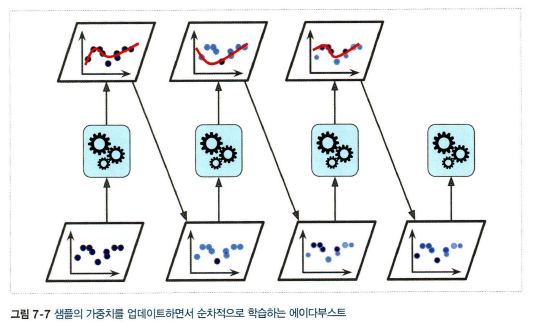

* 연속된 학습 기법
  - 점차 더 좋아지도록 앙상블에 예측기 추가
  - 병렬화(분할) 불가 -> 확장성 떨어짐
* 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지
* 가중치 합이 가장 큰 클래스가 예측 결과

* AdaBoostClassifier (분류)
  * SAMME : 에이다부스트의 다중 클래스 버전
    - 클래스 두 개일 때는 에이다부스트와 동일
  * SAMME.R : 예측기가 클래스의 확률을 추정할 수 있는 경우 사용
    - 성능이 더 좋음
* AdaBoostRegressor (회귀)
* 에이다부스트 앙상블이 훈련 세트에 과대적합 -> 추정기 수 감소, 추정기 규제 강화

  

In [12]:
# 200개 결정 트리 기반 에이다부스트 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier
# AdaBoostClassifier의 기본 추정기
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

#### 7.5.2 그레이디언트 부스팅
* 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
* 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습
* 그레이디언트 트리 부스팅(gradient tree boosting) 또는 그레이디언트 부스티드 회귀 트리(gradient boosted regression tree, GBRT) : 결정 트리 기반 예측기를 사용하는 회귀

In [21]:
# 잡음이 섞인 2차 곡선 형태의 훈련 세트 생성
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [22]:
# DecisionTreeRegresssor를 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [23]:
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [24]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [25]:
# 새로운 샘플 생성
X_new = np.array([[0.8]])

In [28]:
# 세 개의 모델을 포함하는 앙상블 모델을 이용하여 새로운 샘플에 대한 예측 생성
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

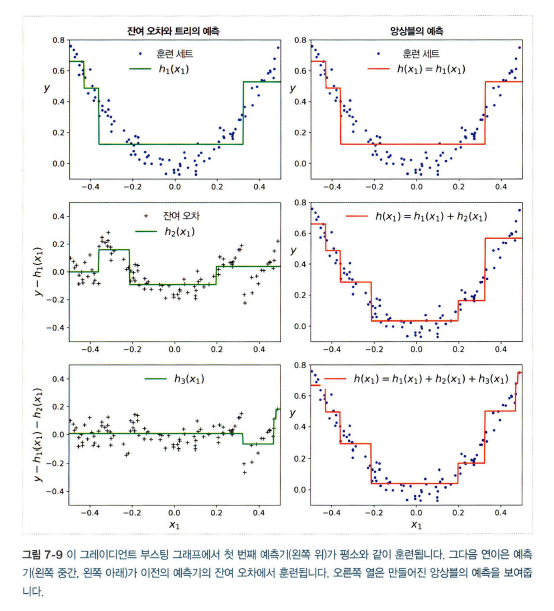

* GradientBoostingRegressor : GBRT 앙상블 훈련

In [29]:
# 동일한 앙상블을 GradientBoostingRegressor를 사용하여 만듦
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

* learning_rate : 각 트리의 기여 정도 조절
  - 규제 방법
    - 축소 : learning_rate를 낮게 설정
      
      -> 트리 수 증가, 예측 성능 향상

    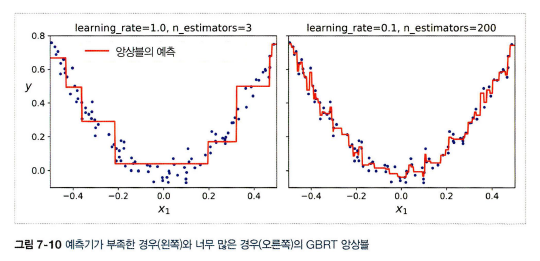 

* 최적의 트리 수 찾기 - 조기 종료
  - staged_predict() 메서드 : 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환

In [30]:
# GBRT 앙상블 훈련 및 최적의 트리 수 찾기
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) # 120개 트리
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] # 각 훈련 단계에서 검증 오차 측정
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

* 실제로 훈련을 중지하는 방법으로 조기 종료 구현 가능
* warm_start = True : fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 함

In [31]:
# 연속 다섯 번의 반복 동안 검증 오차 향상이 없으면 훈련 중지
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators  in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # 조기 종료

* subsample : 각 트리가 훈련할 때 사용할 훈련 샘플이 비율 지정
  - 예: subsample = 0.25 -> 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습 -> 편향 증가, 분산 감소, 훈련 속도 높임

    => 확률적 그레이디언트 부스팅(stochastic gradient boosting)

* XGBoost
  - 최적화된 그레이디언트 부스팅 구현
  - 매우 빠른 속도, 확장성, 이식성
  - 자동 조기 종료 기능 제공

In [32]:
# XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[08:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
# XGBoost의 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[08:20:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.275313
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.247499
[2]	validation_0-rmse:0.222947
[3]	validation_0-rmse:0.201049
[4]	validation_0-rmse:0.181641
[5]	validation_0-rmse:0.166735
[6]	validation_0-rmse:0.153621
[7]	validation_0-rmse:0.141686
[8]	validation_0-rmse:0.131314
[9]	validation_0-rmse:0.122047
[10]	validation_0-rmse:0.112234
[11]	validation_0-rmse:0.10366
[12]	validation_0-rmse:0.097232
[13]	validation_0-rmse:0.092018
[14]	validation_0-rmse:0.087123
[15]	validation_0-rmse:0.083105
[16]	validation_0-rmse:0.079681
[17]	validation_0-rmse:0.076621
[18]	validation_0-rmse:0.074141
[19]	validation_0-rmse:0.071896
[20]	validation_0-rmse:0.070115
[21]	validation_0-rmse:0.068281
[22]	validation_0-rmse:0.066894
[23]	validation_0-rmse:0.065783
[24]	validation_0-rmse:0.064704
[25]	validation_0-rm

### 7.6 스태킹
* 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련
* 블렌더(blender) 또는 메타 학습기(meta learner) : 마지막 예측기

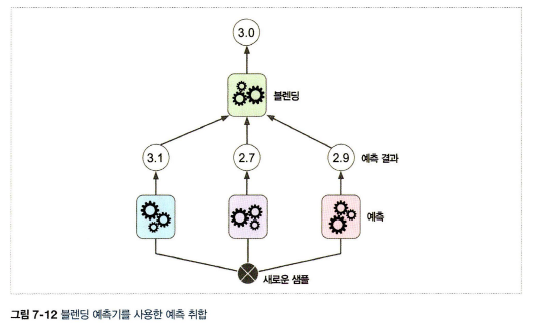

  - 홀드 아웃(hold-out) 세트를 사용하여 학습시킴 : 블렌딩
  - 아웃 오브 폴드(out-of-fold) 예측(k-겹 교차 검증에서 검증 폴드의 결과를 모두 모은 것) 사용하여 학습시킴 : 스태킹